In [1]:
import tensorflow as tf
import numpy as np
import pickle
import pandas
import matplotlib.pyplot as plt

In [2]:
filepath = 'local_data/extrapData/ACTS_ttbarWithOverlay_mu0_0.pkl'
with open(filepath, 'rb') as pFile:
    _ = pickle.load(pFile, encoding='latin1')
    _ = pickle.load(pFile, encoding='latin1')

    x_train = pickle.load(pFile, encoding='latin1')
    x_test = pickle.load(pFile,  encoding='latin1')
    x_train_flat = pickle.load(pFile,  encoding='latin1')
    x_test_flat = pickle.load(pFile,  encoding='latin1')
    x_train_layer = pickle.load(pFile,  encoding='latin1')
    x_test_layer = pickle.load(pFile,  encoding='latin1')

    _ = pickle.load(pFile,  encoding='latin1')
    _ =  pickle.load(pFile,  encoding='latin1')
    _ = pickle.load(pFile,  encoding='latin1')
    _ = pickle.load(pFile,  encoding='latin1')

    y_train = pickle.load(pFile,  encoding='latin1')
    y_test = pickle.load(pFile,  encoding='latin1')

    _ = pickle.load(pFile,  encoding='latin1')
    _ = pickle.load(pFile,  encoding='latin1')

    pt_train = pickle.load(pFile,  encoding='latin1')
    pt_test = pickle.load(pFile,  encoding='latin1')

# x_data, y_data, pt_data = dataWindow(3, x_train_flat, x_train_layer, pt_train)
# x_data_test, y_data_test, pt_data_test = dataWindow(3, x_test_flat, x_test_layer, pt_test)

In [10]:
len(x_train_layer.layerID1.unique())

8

In [9]:
x_train_layer.iloc[3]

detectorID0      0
detectorID1      1
detectorID2      1
detectorID3      1
detectorID4      1
detectorID5      1
detectorID6      1
detectorID7      1
detectorID8      1
detectorID9      1
detectorID10     1
detectorID11     1
detectorID12     0
detectorID13     0
detectorID14     0
layerID0         4
layerID1        16
layerID2        14
layerID3        14
layerID4        12
layerID5        12
layerID6        12
layerID7        10
layerID8         8
layerID9         6
layerID10        4
layerID11        2
layerID12        0
layerID13        0
layerID14        0
Name: 49851, dtype: int32

In [11]:
x_train_layer.layerID1.unique()

array([ 4,  8, 16,  2,  6, 14, 10, 12], dtype=int32)

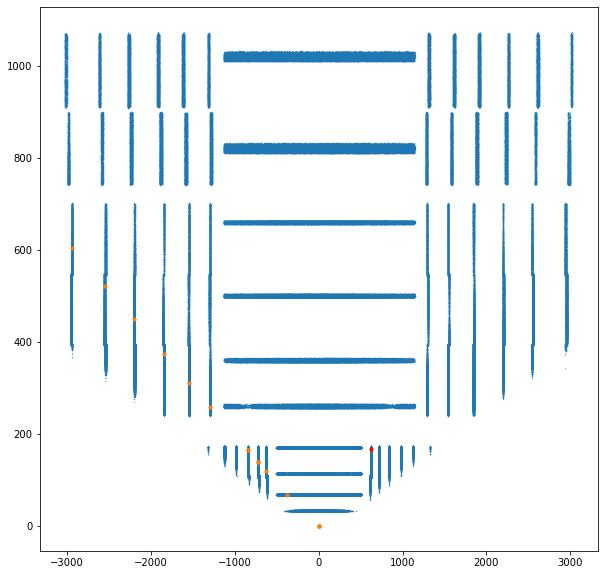

In [3]:
hit = 3
fig=plt.figure(figsize=(10,10))
plt.scatter(x_train_flat[:, 30:45], np.sqrt(x_train_flat[:,15:30]**2+x_train_flat[:,0:15]**2), s=.05)
plt.scatter(x_train_flat[hit, 30:45], np.sqrt(x_train_flat[hit,15:30]**2+x_train_flat[hit,0:15]**2), s=10)
plt.scatter(622,168,s=10,color='red')

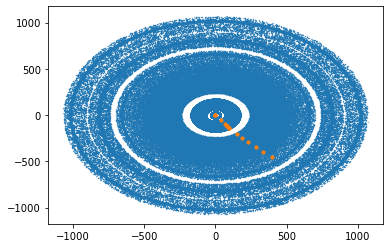

In [5]:
plt.scatter(x_train_flat[:, 0:15], x_train_flat[:,15:30], s=.05)
plt.scatter(x_train_flat[3, 0:15], x_train_flat[3,15:30], s=10)

In [13]:
def detectorInfo_to_featureVector(detectorInfoLoc, cols, nhits):
    track = []
    for i in range(nhits):
        zeros = np.zeros((17,)) # first spot is 0/1 for barrel/ec. Next 12 are One-hot-encoded layer id
        vol_id = detectorInfoLoc[cols[i]]
        layer_idx = detectorInfoLoc[cols[i+15]]
        zeros[0] = vol_id
        if layer_idx !=0: zeros[layer_idx] = 1
        track.append(zeros)
    return np.asarray(track)

In [14]:
def dataWindowACTS(window_size, tracks, detectorInfo, n_features=3, barrelOnly=False, endcapOnly=False):
    #Input (tracks) should be an array of shape (n_samples, n_hits*n_features where the features are listed as x0, y0, z0, x1, y2, z2, ...)
    # returns an x array of size (n_samples, window_size, n_features)
    # returns a y array of size (n_samples, n_features)
    seeds = []
    targets = []
    cols = detectorInfo.columns
    #for i in range(1):
    for i in range(tracks.shape[0]):

        track = tracks[i]
        x=track[0:15]
        y=track[15:30]
        z=track[30:]
        detectorID = detectorInfo.iloc[i]
        new_track = None
        
        nHits = np.where(track==0)[0] 
        if not np.any(nHits): nHits = 15
        else: nHits = nHits[0]
        
        # use only a single hit per layer
        # ensure that hits are in consecutive layers. Layer id should incriment by 2
        # if it doesn't i.e 8->2, the next layer_id should be 2 (the first layer of a new volume)
        detectorFeatures = detectorInfo_to_featureVector(detectorID, cols, nHits)
        detector = np.array([])
        indices = []
        
        for j in range(nHits):
            currentDetector = detectorFeatures[j]
            if np.array_equal(detector, currentDetector): continue
            detector = currentDetector
            indices.append(j)
        nHits = len(indices)
        new_track = np.append(x[indices].reshape(nHits,1), y[indices].reshape(nHits,1),axis=1)
        new_track = np.append(new_track, z[indices].reshape(nHits,1), axis=1)
        new_track = np.append(new_track, detectorFeatures[indices], axis=1)

        for w in range(nHits - window_size):

            seed = new_track[w:w+window_size].reshape(1,window_size,n_features)
            target = new_track[w+window_size].reshape(n_features)
            if (barrelOnly and ((np.any(seed[:,:,3] == 1)) or (np.any(target[3]==1)))): break
            if (endcapOnly and ((np.any(seed[:,:,3] == 0)) or (np.any(target[3]==0)))): break
            seeds.append(seed)
            targets.append(target)
        if i%10000 == 0: print("completed", i, "tracks")


    seeds = np.asarray(seeds)
    targets = np.asarray(targets)
    
    return seeds.reshape(-1,window_size,n_features), targets.reshape(-1,n_features)

In [15]:
from timeit import default_timer as timer

start = timer()
x,y = dataWindowACTS(3, x_train_flat, x_train_layer,20, True, False)
end = timer()
print(end-start)

completed 0 tracks
completed 10000 tracks
completed 20000 tracks
completed 30000 tracks
completed 40000 tracks
completed 50000 tracks
14.23011152700019


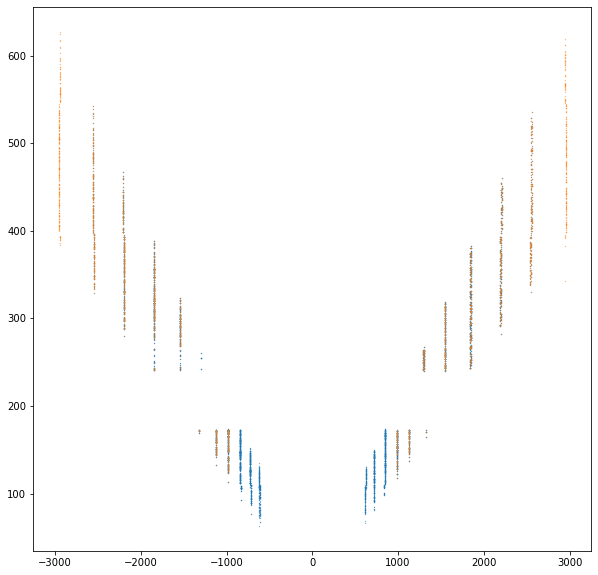

In [15]:
fig=plt.figure(figsize=(10,10))
plt.scatter(x[:,:, 2], np.sqrt(x[:,:, 0]**2+x[:,:, 1]**2), s=.05)
plt.scatter(y[:, 2], np.sqrt(y[:, 0]**2+y[:, 1]**2), s=.05)

In [24]:
from sklearn.utils import shuffle
xs, ys = shuffle(x,y)

In [16]:
maximumx=0
maximumy=0
maximumz=0
for i in x:
    mx = max(i[:,0])
    my = max(i[:,1])
    mz = max(i[:,2])
    if mx > maximumx: maximumx=mx
    if my > maximumy: maximumy=my
    if mz > maximumz: maximumz=mz
print("max X: ", maximumx, " max Y: ", maximumy, " max Z: ", maximumz)

max X:  826.9286499023438  max Y:  822.61669921875  max Z:  954.5341796875


In [17]:
maximumx=0
maximumy=0
maximumz=0
for i in y:
    mx = i[0]
    my = i[1]
    mz = i[2]
    if mx > maximumx: maximumx=mx
    if my > maximumy: maximumy=my
    if mz > maximumz: maximumz=mz
print("max X: ", maximumx, " max Y: ", maximumy, " max Z: ", maximumz)

max X:  1027.0443115234375  max Y:  1030.54345703125  max Z:  1145.2142333984375


In [169]:
i

array([ 699.68615723,  756.0501709 , -578.84680176,    0.        ,
          0.        ,    0.        ,    0.        ,    1.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ])

In [103]:
maximumy

1030.9397

In [104]:
maximumz

1144.8292

In [92]:
np.where(Y[:,0] > 0)

(array([     114,      115,      116, ..., 21995223, 21995224, 21995225]),)

In [93]:
Y[114]

array([ 524.47815, -396.1049 ,  344.41278], dtype=float32)

In [17]:
l = [np.array([1,1]), np.array([2,2]), np.array([3,3])]

In [51]:
import os
import threading
t1 = threading.Thread(target=dataWindowACTS,args=(3, x_train_flat[0:300000]))
t1 = threading.Thread(target=dataWindowACTS,args=(3, x_test_flat[0:300000]))

In [59]:
X = None
Y = None
Xl = []
Yl = []
start = timer()

#for data in ["Athena_ttbar_mu0_2.pkl"]:
for data in os.listdir('local_data/extrapData'):
        if not 'ACTS' in data: continue 
        print("starting", data)
        with open(os.path.join('local_data/extrapData', data),'rb') as pFile:
            _ = pickle.load(pFile, encoding='latin1')
            _ = pickle.load(pFile, encoding='latin1')

            x_train = pickle.load(pFile, encoding='latin1')
            x_test = pickle.load(pFile,  encoding='latin1')
            x_train_flat = pickle.load(pFile,  encoding='latin1')
            x_test_flat = pickle.load(pFile,  encoding='latin1')
            x_train_layer = pickle.load(pFile,  encoding='latin1')
            x_test_layer = pickle.load(pFile,  encoding='latin1')

            _ = pickle.load(pFile,  encoding='latin1')
            _ =  pickle.load(pFile,  encoding='latin1')
            _ = pickle.load(pFile,  encoding='latin1')
            _ = pickle.load(pFile,  encoding='latin1')

            y_train = pickle.load(pFile,  encoding='latin1')
            y_test = pickle.load(pFile,  encoding='latin1')

            _ = pickle.load(pFile,  encoding='latin1')
            _ = pickle.load(pFile,  encoding='latin1')

            pt_train = pickle.load(pFile,  encoding='latin1')
            pt_test = pickle.load(pFile,  encoding='latin1')

            x_data, y_data = dataWindowACTS(3, x_train_flat[0:300000])
            x_data_test, y_data_test = dataWindowACTS(3, x_test_flat[0:300000])
            
#             Xl.append(x_data)
#             Yl.append(y_data)

            if X is None:
                X = x_data
                Y = y_data
                X = np.append(X, x_data_test, axis=0)
                Y = np.append(Y, y_data_test, axis=0)
            else:
                X = np.append(X, x_data, axis=0)
                Y = np.append(Y, y_data, axis=0)
                X = np.append(X, x_data_test, axis=0)
                Y = np.append(Y, y_data_test, axis=0)
            print("finished file")
end = timer()
print(end-start)

starting ACTS_ttbarWithOverlay_mu0_0.pkl
completed 0 tracks
completed 10000 tracks
completed 20000 tracks
completed 30000 tracks
completed 40000 tracks
completed 50000 tracks
completed 60000 tracks
completed 70000 tracks
completed 80000 tracks
completed 90000 tracks
completed 100000 tracks
completed 110000 tracks
completed 120000 tracks
completed 130000 tracks
completed 140000 tracks
completed 150000 tracks
completed 160000 tracks
completed 170000 tracks
completed 180000 tracks
completed 190000 tracks
completed 200000 tracks
completed 210000 tracks
completed 220000 tracks
completed 230000 tracks
completed 240000 tracks
completed 250000 tracks
completed 260000 tracks
completed 270000 tracks
completed 280000 tracks
completed 290000 tracks
completed 0 tracks
completed 10000 tracks
completed 20000 tracks
completed 30000 tracks
completed 40000 tracks
completed 50000 tracks
completed 60000 tracks
completed 70000 tracks
completed 80000 tracks
completed 90000 tracks
completed 100000 tracks
com

In [64]:
def tracksACTS(tracks, detectorInfo, n_features=3, barrelOnly=False, endcapOnly=False):
    #Input (tracks) should be an array of shape (n_samples, n_hits*n_features where the features are listed as x0, y0, z0, x1, y2, z2, ...)
    # returns an x array of size (n_samples, window_size, n_features)
    # returns a y array of size (n_samples, n_features)
    completeTracks = []
    cols = detectorInfo.columns
    #for i in range(2):
    for i in range(tracks.shape[0]):

        track = tracks[i]
        x=track[0:15]
        y=track[15:30]
        z=track[30:]
        detectorID = detectorInfo.iloc[i]
        new_track = None
        
        nHits = np.where(track==0)[0] 
        if not np.any(nHits): nHits = 15
        else: nHits = nHits[0]
        
        # use only a single hit per layer
        detectorFeatures = detectorInfo_to_featureVector(detectorID, cols, nHits)
        detector = np.array([])
        indices = []
        for j in range(nHits):
            currentDetector = detectorFeatures[j]
            if np.array_equal(detector, currentDetector): continue #check that the next hit is in a new layer
            detector = currentDetector
            indices.append(j)
        nHits = len(indices)
        new_track = np.append(x[indices].reshape(nHits,1), y[indices].reshape(nHits,1),axis=1)
        new_track = np.append(new_track, z[indices].reshape(nHits,1), axis=1)
        new_track = np.append(new_track, detectorFeatures[indices], axis=1)
        #new_track = new_track.reshape(1, len(new_track), n_features)
        
        if (barrelOnly):
            idx = np.where(new_track[:,3]==1)[0] #find where the endcap hits begin
            if len(idx) > 0: new_track = new_track[:idx[0]] #select up to the endcap hits
                
        if len(new_track) < 15:
            zeros = np.zeros((15-len(new_track), n_features))
            #zeros = zeros[np.newaxis,:,:]
            new_track = np.append(new_track, zeros, axis=0)

        
        if i%10000 == 0: print("completed", i, "tracks")
        
        completeTracks.append(new_track)
        
    completeTracks = np.asarray(completeTracks)
    inputs = completeTracks[:, :-1, :]
    targets = completeTracks[:, 1:, :]
    
    return inputs, targets

In [65]:
x,y = tracksACTS(x_train_flat, x_train_layer,20, True)


completed 0 tracks
completed 10000 tracks
completed 20000 tracks
completed 30000 tracks
completed 40000 tracks
completed 50000 tracks


In [67]:
x[0]

array([[ 3.30430412e+01,  6.44404173e+00, -3.74030380e+01,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 6.71210175e+01,  1.25561886e+01, -2.93075905e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.11885735e+02,  1.97436314e+01, -1.87063255e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.0